<a href="https://colab.research.google.com/github/OsirisEscaL/Parkinson_Project/blob/main/GaussianNB_Parkinson_HeredetaryAtaxias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector, SelectFromModel, RFE
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
ds = pd.read_csv('Parkinson_HeredetaryAtaxias.csv') # Cambiar dataset
ds = ds.drop(['Unnamed: 0'], axis=1)
X = ds.iloc[:, 0:-1].values
y = ds.iloc[:, -1].values

rng = np.random.default_rng(seed=42)
random = rng.integers(10000, size=50)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [3]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

Oversampling

In [4]:
methods = [
    ("Random Over Sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ("ADASYN", ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)),
    ("BorderlineSMOTE", BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("SVMSMOTE", SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("KMeansSMOTE", KMeansSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2, cluster_balance_threshold=0.01))
]

In [5]:
results = {}
results_raw = {}

for method_name, method in methods:
    sample_x, sample_y = method.fit_resample(scaled_X, y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for num in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=num)
        for train_index, test_index in stratified_kfold.split(sample_x,sample_y):
            X_train, X_test = sample_x[train_index], sample_x[test_index]
            y_train, y_test = sample_y[train_index], sample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[method_name] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[method_name] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
results_raw_over_ds = pd.DataFrame(results_raw)
results_raw_over_ds.to_csv('Results_Raw_Oversampling_GaussianNB.csv')

In [7]:
results_over_ds = pd.DataFrame(results).T
results_over_ds.to_csv('Results_Oversampling_GaussianNB.csv')
results_over_ds

,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
Random Over Sampler,0.634564,0.029232,0.635039,0.029746,0.627283,0.032261,0.712145,0.036326,0.556982,0.050609,0.659689,0.026508,0.634564,0.029232
SMOTE,0.738218,0.027602,0.738831,0.027729,0.736764,0.026848,0.764618,0.039202,0.711818,0.029051,0.742193,0.028835,0.738218,0.027602
ADASYN,0.684427,0.026350,0.683091,0.026598,0.659617,0.030399,0.738218,0.038331,0.630636,0.039500,0.689602,0.027224,0.684427,0.026350
BorderlineSMOTE,0.698945,0.029667,0.699126,0.030108,0.708434,0.039100,0.691564,0.036367,0.706327,0.051534,0.691551,0.029846,0.698945,0.029667
SVMSMOTE,0.658550,0.036489,0.666222,0.037249,0.729346,0.035246,0.701600,0.049949,0.615500,0.050778,0.707013,0.036801,0.658550,0.036489
KMeansSMOTE,0.725527,0.029128,0.725108,0.029145,0.732742,0.038658,0.729273,0.042678,0.721782,0.050803,0.721500,0.030624,0.725527,0.029128


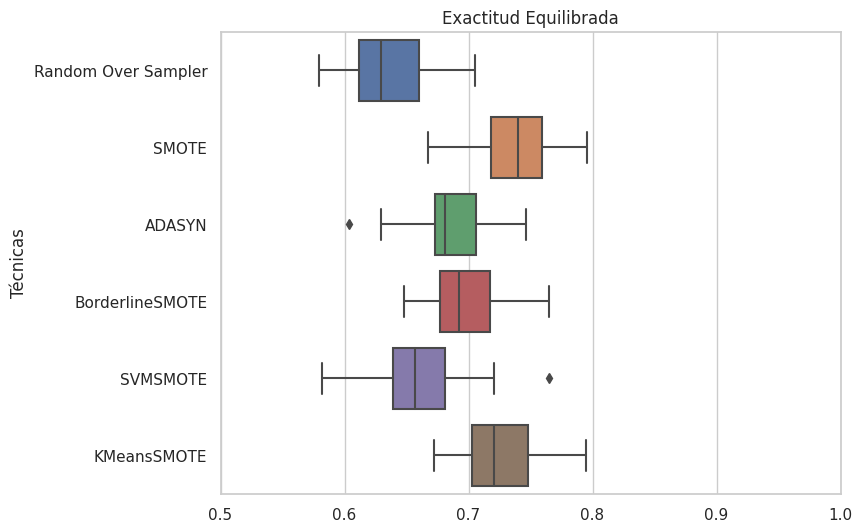

In [8]:
balanced_accuracy = pd.DataFrame(results_raw_over_ds.loc['Balanced_Accuracy'])
modelos = balanced_accuracy.index

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=balanced_accuracy['Balanced_Accuracy'], orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.5, 1)
plt.ylabel('Técnicas')
plt.gca().set_yticklabels(modelos)
plt.savefig('Boxplot_Oversampling_GaussianNB.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
samplers = ['Random Over Sampler', 'SMOTE', 'ADASYN', 'BorderlineSMOTE',
            'SVMSMOTE', 'KMeansSMOTE']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = results_raw_over_ds.loc['Balanced_Accuracy', sample1]
  for sample2 in samplers:
    val2 = results_raw_over_ds.loc['Balanced_Accuracy', sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

In [10]:
comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_Oversampling_GaussianNB.csv')
comparison

statistic   p_value  \
Random Over Sampler Random Over Sampler    1250.0       1.0   
SMOTE               Random Over Sampler    2484.5       0.0   
                    SMOTE                  1250.0       1.0   
                    ADASYN                 2299.0       0.0   
                    BorderlineSMOTE        2072.5       0.0   
                    SVMSMOTE               2380.0       0.0   
                    KMeansSMOTE            1587.0  0.010171   
ADASYN              Random Over Sampler    2225.5       0.0   
                    ADASYN                 1250.0       1.0   
                    BorderlineSMOTE         968.0  0.052296   
                    SVMSMOTE               1825.0  0.000037   
BorderlineSMOTE     Random Over Sampler    2337.5       0.0   
                    ADASYN                 1532.0  0.052296   
                    BorderlineSMOTE        1250.0       1.0   
                    SVMSMOTE               2011.0       0.0   
SVMSMOTE            Random Over Sampler    1742.5  0.000347   
                    SVMSMOTE               1250.0       1.0   
KMeansSMOTE         Random Over Sampler    2467.5       0.0   
                    ADASYN                 2115.0       0.0   
                    BorderlineSMOTE        1839.0  0.000025   
                    SVMSMOTE               2307.0       0.0   
                    KMeansSMOTE            1250.0       1.0   

                                                                                   greater  
Random Over Sampler Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
SMOTE               Random Over Sampler  La primera muestra es significativamente mayor...  
                    SMOTE                No hay evidencia suficiente para afirmar que l...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          La primera muestra es significativamente mayor...  
ADASYN              Random Over Sampler  La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
BorderlineSMOTE     Random Over Sampler  La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
SVMSMOTE            Random Over Sampler  La primera muestra es significativamente mayor...  
                    SVMSMOTE             No hay evidencia suficiente para afirmar que l...  
KMeansSMOTE         Random Over Sampler  La primera muestra es significativamente mayor...  
                    ADASYN               La primera muestra es significativamente mayor...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          No hay evidencia suficiente para afirmar que l...

Feature Selection

In [11]:
oversampler = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5) # Cambiar dependiendo cual fue mejor
oversample_X, oversample_y = oversampler.fit_resample(scaled_X, y)

In [12]:
ds_X = ds.iloc[:, 0:-1]
features = ds_X.shape[1]

In [13]:
# SelectKBest
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectKBest(score_func=f_classif, k=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

In [14]:
results_raw_selectK_ds = pd.DataFrame(results_raw)
results_raw_selectK_ds.to_csv('Results_Raw_SelectKBest_GaussianNB.csv')

In [15]:
results_selectK_ds = pd.DataFrame(results).T
number_of_features = results_selectK_ds.index + 1
results_selectK_ds.insert(0, 'Number_Features', number_of_features)
results_selectK_ds = results_selectK_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_selectK_ds.to_csv('Results_SelectKBest_GaussianNB.csv')
results_selectK_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
19,20,0.790745,0.024014,0.791368,0.023828,0.793182,0.030337,0.810364,0.027885,0.771127,0.036419,0.794962,0.023765,0.790745,0.024014
17,18,0.788600,0.023830,0.789411,0.023243,0.781099,0.025500,0.825927,0.033506,0.751273,0.030219,0.796333,0.024941,0.788600,0.023830
18,19,0.788200,0.023365,0.788909,0.022994,0.786506,0.027785,0.817855,0.027371,0.758545,0.033091,0.794775,0.023012,0.788200,0.023365
21,22,0.787527,0.020777,0.788173,0.020810,0.789250,0.028306,0.808982,0.025847,0.766073,0.032803,0.792365,0.021198,0.787527,0.020777
20,21,0.782800,0.020240,0.783429,0.020111,0.782405,0.026972,0.808255,0.025949,0.757345,0.031076,0.788472,0.020604,0.782800,0.020240


In [17]:
best_number_K = 20 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_K = SelectKBest(score_func=f_classif, k=best_number_K)
new_X_K = selector_K.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_K.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectKBest:")
print(selected_feature_names)

Características seleccionadas usando SelectKBest:
Index(['Mean_step_lenght_Der', 'Velocity_Der', 'RMS_AP_Der', 'Freq_90_ML_Der',
       'Freq_100_ML_Der', 'IPSD_AP_Der', 'Freq_90_AP_Der', 'Freq_100_AP_Der',
       'Sym_AP_Der', 'Stride_Reg_ML_Der', 'Cadence_Izq', 'Velocity_Izq',
       'RMS_ML_Izq', 'RMS_AP_Izq', 'Freq_50_VER_Izq', 'Freq_75_VER_Izq',
       'Freq_90_VER_Izq', 'Freq_100_VER_Izq', 'IPSD_ML_Izq',
       'Stride_Reg_AP_Izq'],
      dtype='object')


In [18]:
# Sequential Feature Selector
results = {}
results_raw = {}

for num in range(1, features):
    selector = SequentialFeatureSelector(model, n_features_to_select=num, direction='forward', cv=5, scoring='balanced_accuracy')
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

In [19]:
results_raw_sequential_ds = pd.DataFrame(results_raw)
results_raw_sequential_ds.to_csv('Results_Raw_Sequential_GaussianNB.csv')

In [20]:
results_sequential_ds = pd.DataFrame(results).T
number_of_features = results_sequential_ds.index + 1
results_sequential_ds.insert(0, 'Number_Features', number_of_features)
results_sequential_ds = results_sequential_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_sequential_ds.to_csv('Results_Sequential_GaussianNB.csv')
results_sequential_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
7,8,0.836145,0.024575,0.836242,0.024352,0.830437,0.027133,0.861345,0.028521,0.810945,0.032920,0.840186,0.023712,0.836145,0.024575
6,7,0.833182,0.020948,0.833186,0.020792,0.825148,0.028439,0.862800,0.021468,0.803564,0.034559,0.837706,0.018986,0.833182,0.020948
5,6,0.828891,0.020350,0.829030,0.020123,0.819746,0.026914,0.862036,0.018929,0.795745,0.032960,0.834508,0.018409,0.828891,0.020350
8,9,0.824109,0.025869,0.824190,0.025843,0.817206,0.028549,0.854618,0.030420,0.793600,0.035402,0.829376,0.025829,0.824109,0.025869
4,5,0.818945,0.022122,0.819117,0.021971,0.811828,0.027317,0.849818,0.021346,0.788073,0.034275,0.825015,0.020099,0.818945,0.022122


In [21]:
best_number_Q = 8 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_Q = SequentialFeatureSelector(model, n_features_to_select=best_number_Q, direction='forward', cv=5, scoring='balanced_accuracy')
new_X_Q = selector_Q.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_Q.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SequentialFeatureSelector:")
print(selected_feature_names)

Características seleccionadas usando SequentialFeatureSelector:
Index(['Velocity_Der', 'RMS_ML_Der', 'IPSD_VER_Der', 'Freq_90_AP_Der',
       'Sym_VER_Der', 'RMS_ML_Izq', 'Freq_75_VER_Izq', 'Step_Reg_AP_Izq'],
      dtype='object')


In [23]:
raw_SelectKBest = results_raw_selectK_ds.iloc[0, best_number_K-1]
raw_Sequential = results_raw_sequential_ds.iloc[0, best_number_Q-1]

raw_SelectKBest = pd.Series(raw_SelectKBest, name='SelectKBest')
raw_Sequential = pd.Series(raw_Sequential, name='Sequential Feature Selector')


FeaturesSelectors = pd.concat([raw_SelectKBest, raw_Sequential], axis=1)

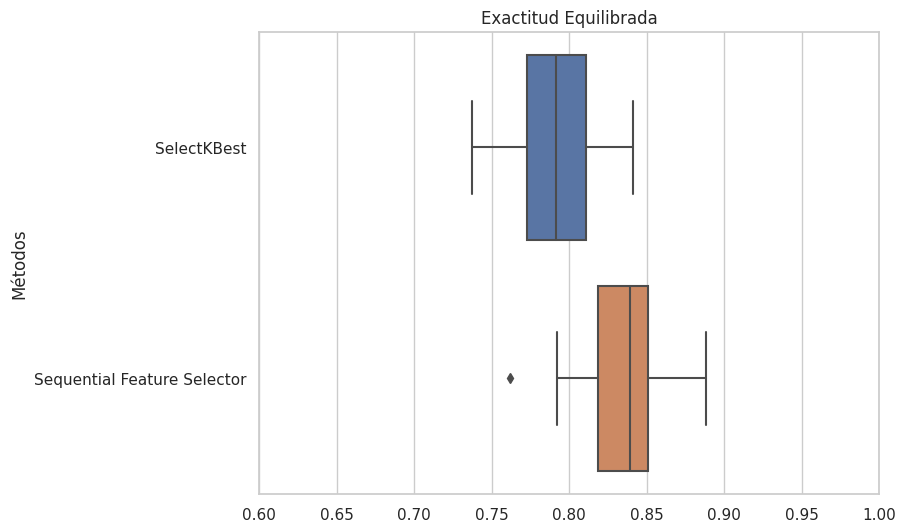

In [26]:
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=FeaturesSelectors, orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.6, 1)
plt.ylabel('Métodos')
plt.savefig('Boxplot_FeatureSelection_GaussianNB.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
samplers = ['SelectKBest', 'Sequential Feature Selector']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = FeaturesSelectors.loc[:, sample1]
  for sample2 in samplers:
    val2 = FeaturesSelectors.loc[:, sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

In [28]:
comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_FeaturesSelection_GaussianNB.csv')
comparison

statistic p_value  \
SelectKBest                 SelectKBest                    1250.0     1.0   
Sequential Feature Selector SelectKBest                    2264.0     0.0   
                            Sequential Feature Selector    1250.0     1.0   

                                                                                                   greater  
SelectKBest                 SelectKBest                  No hay evidencia suficiente para afirmar que l...  
Sequential Feature Selector SelectKBest                  La primera muestra es significativamente mayor...  
                            Sequential Feature Selector  No hay evidencia suficiente para afirmar que l...

SelectFromModel y RFE  no son directamente aplicable a algoritmos como SVC (Support Vector Classifier), GaussianNB (Naive Bayes Gaussiano) y KNeighborsClassifier cuando se utilizan en su forma estándar. La razón principal es que estos algoritmos no proporcionan directamente medidas de importancia de características (como los coeficientes en modelos lineales) que RFE utiliza para seleccionar y eliminar características de forma iterativa.

Para entenderlo mejor:

SVC (Support Vector Classifier): Los clasificadores SVM no tienen un concepto claro de importancia de características como lo hacen los modelos lineales. Los vectores de soporte y los hiperplanos de separación se determinan en función de las distancias y relaciones entre los puntos de datos en un espacio dimensional más alto. No hay coeficientes de características que puedas eliminar directamente.

GaussianNB (Naive Bayes Gaussiano): El clasificador Naive Bayes Gaussiano asume independencia entre las características y modela la distribución de las características utilizando estadísticas como la media y la varianza. No proporciona coeficientes de características que puedan utilizarse en RFE.

KNeighborsClassifier: KNeighborsClassifier es un algoritmo basado en instancias que se basa en comparaciones de distancia entre puntos de datos en el espacio de características. No tiene coeficientes de características que se puedan eliminar como en modelos lineales.

Hyperparameter Tunning

In [29]:
best_number = 9 # Cambiar dependiendo cual fue mejor
selector = SequentialFeatureSelector(model, n_features_to_select=best_number, direction='forward', cv=5, scoring='balanced_accuracy')
new_X = selector.fit_transform(oversample_X, oversample_y)

El clasificador Naive Bayes Gaussiano (Gaussian Naive Bayes) en scikit-learn no tiene hiperparámetros que se puedan ajustar a través de una búsqueda exhaustiva como la búsqueda en cuadrícula o la búsqueda aleatoria, ya que se basa en suposiciones muy simples sobre la distribución de los datos. En el caso de Gaussian Naive Bayes, el único parámetro que se puede especificar es la varianza mínima (var_smoothing).

La varianza mínima (var_smoothing) se utiliza para evitar problemas de convergencia cuando se calculan las probabilidades condicionales en el modelo Naive Bayes. Su valor predeterminado es 1e-9, lo que generalmente funciona bien para muchos conjuntos de datos. Sin embargo, en algunos casos, puede ser útil ajustar este valor para mejorar el rendimiento del modelo.

Resultados y Curva ROC

In [31]:
model_best = GaussianNB()

In [32]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model_best.fit(X_train, y_train)
        y_pred = model_best.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['GaussianNB'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

In [33]:
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
GaussianNB,0.82419,0.824109,0.829376,0.817206,0.824109,0.854618,0.7936,0.025843,0.025869,0.025829,0.028549,0.025869,0.03042,0.035402


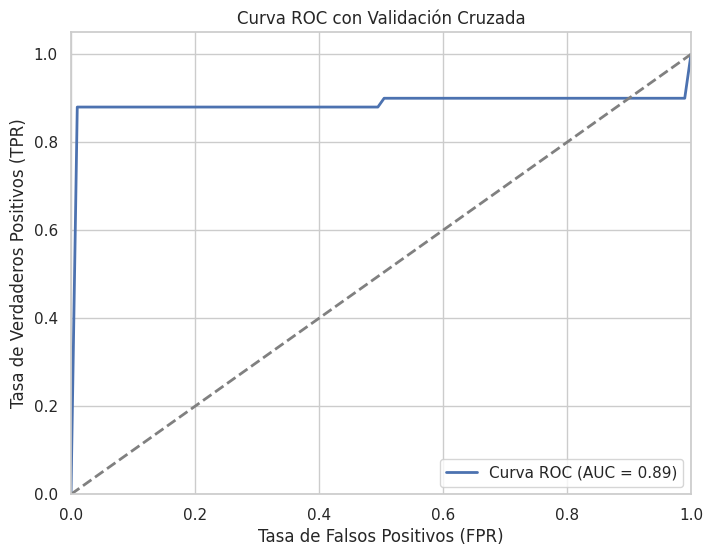

In [34]:
cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_index, test_index in cv.split(new_X, oversample_y):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = oversample_y[train_index], oversample_y[test_index]
    model_best.fit(X_train, y_train)
    y_pred_prob = model_best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

mean_tpr = np.mean(tprs, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Validación Cruzada')
plt.legend(loc='lower right')
plt.savefig('ROCCurve_GaussianNB.png', dpi=300, bbox_inches='tight')
plt.show()